In [43]:
import pandas as pd
import os
import s3fs # for reading from S3FileSystem
import json

%matplotlib inline
import matplotlib.pyplot as plt


import torch.nn as nn
import torch
import torch.utils.model_zoo as model_zoo
import numpy as np

import torchvision.models as models # To get ResNet18

# From - https://github.com/cfotache/pytorch_imageclassifier/blob/master/PyTorch_Image_Inference.ipynb
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from PIL import Image
from torch.autograd import Variable

from torch.utils.data.sampler import SubsetRandomSampler

# Prepare the Model

In [44]:
SAGEMAKER_PATH = r'/home/ec2-user/SageMaker'

MODEL_PATH = os.path.join(SAGEMAKER_PATH, r'sidewalk-cv-assets19/pytorch_pretrained/models/20e_slid_win_no_feats_r18.pt')

In [45]:
os.path.exists(MODEL_PATH)

True

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [47]:
# Use PyTorch's ResNet18
# https://stackoverflow.com/questions/53612835/size-mismatch-for-fc-bias-and-fc-weight-in-pytorch
model = models.resnet18(num_classes=5)  

In [48]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Prep Data

In [50]:
# From Galen

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# the dataset loads the files into pytorch vectors
#image_dataset = TwoFileFolder(dir_containing_crops, meta_to_tensor_version=2, transform=data_transform)

# the dataloader takes these vectors and batches them together for parallelization, increasing performance
#dataloader    = torch.utils.data.DataLoader(image_dataset, batch_size=4, shuffle=True, num_workers=4)

# this is the number of additional features provided by the dataset
#len_ex_feats = image_dataset.len_ex_feats
#dataset_size = len(image_dataset)

In [74]:
# Load in the data
data_dir = 'raw_images'

data = datasets.ImageFolder(data_dir, transform=test_transforms)
classes = data.classes
classes

['0_fakemissing', '1_null', '2_obstacles', '3_present', '4_surface_prob']

In [72]:
!ls -a raw_images

.   0_fakemissing  2_obstacles	4_surface_prob
..  1_null	   3_present	.ipynb_checkpoints


In [73]:
!rm -f -r raw_images/.ipynb_checkpoints/

In [75]:
# Examine the classes based on folders... 
# Need to make sure that we don't get a .ipynb_checkpoints as a folder
# Discussion here - https://forums.fast.ai/t/how-to-remove-ipynb-checkpoint/8532/19
classes

['0_fakemissing', '1_null', '2_obstacles', '3_present', '4_surface_prob']

In [76]:
num = 30

indices = list(range(len(data)))
print(indices)
np.random.shuffle(indices)
idx = indices[:num]

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

#sampler = SubsetRandomSampler(idx)
loader = torch.utils.data.DataLoader(data, batch_size=num)
dataiter = iter(loader)
images, labels = dataiter.next()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [77]:
len(images)

15

In [78]:
# Look at the first image
images[0]

tensor([[[0.6431, 0.6431, 0.6431,  ..., 0.5294, 0.5294, 0.5294],
         [0.6431, 0.6431, 0.6431,  ..., 0.5294, 0.5294, 0.5294],
         [0.6431, 0.6431, 0.6431,  ..., 0.5294, 0.5294, 0.5294],
         ...,
         [0.6353, 0.6275, 0.5098,  ..., 0.5059, 0.4706, 0.2863],
         [0.6431, 0.6275, 0.6157,  ..., 0.3647, 0.3765, 0.2392],
         [0.6392, 0.6235, 0.6353,  ..., 0.2196, 0.2235, 0.2157]],

        [[0.6588, 0.6588, 0.6588,  ..., 0.5843, 0.5843, 0.5843],
         [0.6588, 0.6588, 0.6588,  ..., 0.5843, 0.5843, 0.5843],
         [0.6588, 0.6588, 0.6588,  ..., 0.5843, 0.5843, 0.5843],
         ...,
         [0.6235, 0.6157, 0.4980,  ..., 0.5059, 0.4706, 0.2863],
         [0.6275, 0.6118, 0.6000,  ..., 0.3647, 0.3765, 0.2392],
         [0.6157, 0.6000, 0.6078,  ..., 0.2196, 0.2235, 0.2157]],

        [[0.6941, 0.6941, 0.6941,  ..., 0.6196, 0.6196, 0.6196],
         [0.6941, 0.6941, 0.6941,  ..., 0.6196, 0.6196, 0.6196],
         [0.6941, 0.6941, 0.6941,  ..., 0.6196, 0.6196, 0.

In [79]:
len(labels)

15

In [80]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [81]:
# Note on how to make sure the model and the input tensors are both on cuda device (gpu)
# https://discuss.pytorch.org/t/runtimeerror-input-type-torch-cuda-floattensor-and-weight-type-torch-floattensor-should-be-the-same/21782/6

In [82]:
def predict_image(image, model):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index, output  

*************************
actual class: 0_fakemissing
predicted class: 1_null
output: tensor([[-1.0634,  3.3065, -1.5593,  1.0756, -1.7252]], device='cuda:0',
       grad_fn=<AddmmBackward>)
Result: False
*************************
actual class: 0_fakemissing
predicted class: 1_null
output: tensor([[-1.0799,  3.2087, -2.6845,  1.5157, -0.9887]], device='cuda:0',
       grad_fn=<AddmmBackward>)
Result: False
*************************
actual class: 0_fakemissing
predicted class: 1_null
output: tensor([[-0.9647,  3.2186, -1.4188,  2.0546, -2.7649]], device='cuda:0',
       grad_fn=<AddmmBackward>)
Result: False
*************************
actual class: 0_fakemissing
predicted class: 1_null
output: tensor([[-1.3545,  3.0314, -2.9607,  2.3150, -0.8690]], device='cuda:0',
       grad_fn=<AddmmBackward>)
Result: False
*************************
actual class: 0_fakemissing
predicted class: 1_null
output: tensor([[-1.2809,  3.1390, -2.9411,  1.2693, -0.1438]], device='cuda:0',
       grad_fn=<Addmm

<Figure size 432x288 with 0 Axes>

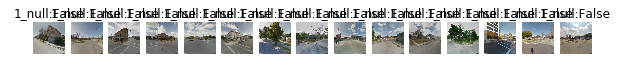

In [83]:
plt.cla()
plt.clf()

to_pil = transforms.ToPILImage()
#images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
short_images = images
for ii in range(len(short_images)):
    image = to_pil(images[ii])
    index, output = predict_image(image, model)
    print('*************************')
    print(f'actual class: {str(classes[int(labels[ii])])}')
    print(f'predicted class: {str(classes[index])}')
    print(f'output: {output}')
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    print(f'Result: {res}')
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [109]:
res

False

# Comments and Questions

What's the order of the labels (and how I should order the folders for the input data?) 

This file implies that there are different orders
https://github.com/ProjectSidewalk/sidewalk-cv-assets19/blob/master/GSVutils/sliding_window.py

```label_from_int = ('Curb Cut', 'Missing Cut', 'Obstruction', 'Sfc Problem')
pytorch_label_from_int = ('Missing Cut', "Null", 'Obstruction', "Curb Cut", "Sfc Problem")```